 # Los Altos Police First Dataset

This is a look at the first Los Altos Police Department dataset. Our analyses are still in flux, but this will show where we are right now.

The RIPA regulations require that each police department publish data on stops. The Los Altos dataset we will be looking at can be found here. https://www.losaltosca.gov/police/page/racial-and-identity-profiling-act-ripa-data

The data is in the form of a large table, where each row represents an encounter, and there are columns with both demographic data about the individual, and details about the actions. Each stop has a unique stop identification number (stop_id).

In [1]:
import pandas as pd
import numpy as np

This csv file is a slight modification of the raw data from LAPD, where the column names are standardized.

In [2]:
df = pd.read_csv("test_df_2.csv")
# index value is in this temp csv
df.drop(df.columns[0], axis=1, inplace=True)
df["date_time"] = pd.to_datetime(df["date_time"], format="%m/%d/%Y %H:%M")

Here are all the columns in the table:

In [3]:
df.keys()

Index(['stop_id', 'date_time', 'duration', 'call_for_service', 'location',
       'actions_taken', 'Person Search Consent Given',
       'Property Search Consent Given', 'basis_for_search', 'reason_for_stop',
       'result', 'limited_english', 'age', 'gender', 'Gender Nonconforming',
       'lgbt', 'race', 'disabilities', 'evidence_found'],
      dtype='object')

## Data integrity

First we will run some basic integrity tests, to make sure there is nothing weird about the dataset.

In [4]:
import integrity.compliance as comp

In [5]:
comp.verbose_checks(df)

All required fields exist: FAIL
   Missing fields: {'property_seized'}
   Extra fields:   {'Person Search Consent Given', 'Gender Nonconforming', 'Property Search Consent Given'}
All stops unique: FAIL
   Total records:   16177
   Unique stop_ids: 1425
   Unique records:  2117
   Duplicate stop_ids: [  72   72   85 ... 2266 2315 2328]


False

There are two problems here.
First, the LAPD data does not have all fields required by the regulations ( https://oag.ca.gov/sites/all/files/agweb/pdfs/ripa/stop-data-reg-final-text-110717.pdf)
This may be because it wasn't collected, or it may be that it was just not included in the data export. We know that they are collecting the officer identification information to report to the state DOJ, but they are not making that public due to privacy concerns.

Also, they seem be colleting some additional fields that are not required. That's okay with us.

Second, there are some things going on with duplicate records. There are 14,060 records that are exact duplicates. We have no idea why that should happen; for the following analysis we'll just throw them away.

The difference between the "Unique records" and "Unique stop_ids" appears to stem from two sources: 1) multiple people stopped together, resulting in one stop_id and multiple records and 2) multiple actions for the same person. 

We'll need to think carefully about some of the implications ("Which person's race was considered when the stop was made?")  For now, the following initial analysis just takes the first record as the relevant one, and throws out the rest.

We can try to estimate how many individuals are involved by using the demographic information.

In [6]:
dup_stops = np.unique(df[df["stop_id"].duplicated(keep=False)]["stop_id"].values)
individuals = [comp.count_individuals(df[df["stop_id"] == id].copy()) for id in dup_stops]

In [7]:
print("In {} stops with multiple records, {} individuals appear to be involved".format(len(dup_stops), sum(individuals)))
single_stops = len(df.drop_duplicates(subset="stop_id", keep=False))
print("Combined with the {} stops with only 1 record, that means {} people were likely stopped.".format(single_stops, single_stops+sum(individuals)))

In 153 stops with multiple records, 202 individuals appear to be involved
Combined with the 1272 stops with only 1 record, that means 1474 people were likely stopped.


According the the LAPD website, the 1425 stops represent 1440 people, so in some cases we are overcounting. We will need to work with LAPD to get more information in the next release so we can sort this out.

In [8]:
# only keep the first record for each stop_id
df_uniq = df.drop_duplicates(subset="stop_id", keep="first")

In [9]:
import integrity.temporal as tp

Now we are going to look at the timing of the stops, to make sure there is nothing weird. We'll look at the total duration of the dataset, we'll makes sure each stop comes after the previous stop_id, and we'll look for gaps and bunching.

Sufficient time duration: PASS
    First stop: 2021-02-01 10:40:00
    Last stop:  2021-07-31 23:36:00
    Duration of data set: 180 days 12:56:00
Stops are in proper time order: PASS
Check for unexpected data gaps: FAIL
Index:   Duration:
3200:  1 days 12:44:00,   2021-02-27 19:43:00 to 2021-03-01 08:27:00
4015:  1 days 02:09:00,   2021-03-03 04:04:00 to 2021-03-04 06:13:00
4183:  1 days 01:23:00,   2021-03-12 12:58:00 to 2021-03-13 14:21:00
4185:  1 days 05:51:00,   2021-03-14 03:43:00 to 2021-03-15 09:34:00
5830:  1 days 01:24:00,   2021-04-03 04:25:00 to 2021-04-04 05:49:00
13724:  1 days 00:39:00,   2021-04-20 09:25:00 to 2021-04-21 10:04:00
13918:  1 days 11:25:00,   2021-05-07 22:26:00 to 2021-05-09 09:51:00
14408:  1 days 00:47:00,   2021-05-28 14:34:00 to 2021-05-29 15:21:00
15306:  1 days 00:02:00,   2021-06-04 20:19:00 to 2021-06-05 20:21:00
15371:  1 days 02:32:00,   2021-06-13 08:33:00 to 2021-06-14 11:05:00
15423:  1 days 10:42:00,   2021-06-17 08:01:00 to 2021-06-18 18:4

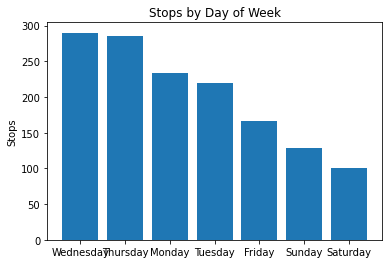

Weekdays with excessive stops: Index(['Wednesday', 'Thursday', 'Sunday', 'Saturday'], dtype='object')



False

In [10]:
tp.verbose_checks(df_uniq)

The first unusual thing we see here is quite a few periods where there are no stops at all. This test reports any time 24 hours go by without a single stop. On average, LAPD makes about 8 stops per day; so it's a little odd to see these periods of time with no stops.

The next set of tests look for bunching of stops. Were there any particular days that had a lot more stops than expected, so much so that we think the data may be corrupted? In this case, the only one that got to extreme levels of difference was the "Day of the Week" stops. There were twice as many stops on Wednesdays and Thursdays as there were on the weekend. This likely reflects staffing and perhaps assignments. 

## Descriptive statistics

Next we will compute some basic descriptive statistics on this dataset. 

This chart shows some of the demographic breakdown of the dataset.

In [11]:
import plotting.lare_matplot as lmp

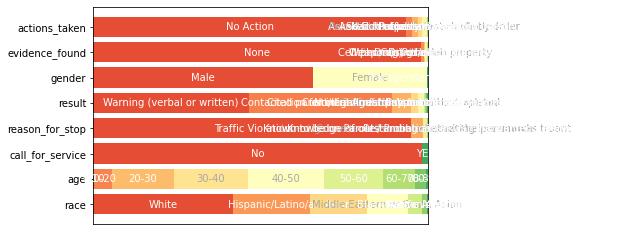

In [12]:
lmp.plot_descriptive_bars(df_uniq)

Without context, it's hard to judge if these are reasonable or unreasonable. In the future, we will gather the data to compare these breakdowns to other towns, and for demographics to the population at large.

## Basic analysis

The simplest way of looking at racial disparities it to just look at the number of stops by race, divided by the Los Altos population of that race. This tells us how many "stops per capita" there are by race.

"Simple" methods nearly always miss nuance. Of course, the number of stops the police make depend on the number of people actually in Los Altos, not the number of people with a Los Altos address. So it's always possible that greater numbers of one race than another are In Los Altos without being counted in the population of Los Altos.

Nevertheless, let's look at those raw numbers. We'll take the number of stops by race, and divide by the population by race.

In [19]:
import analysis.populations as pop

In [20]:
la_pop = pop.get_population("Los Altos")

In [21]:
(df_uniq["race"].value_counts()/la_pop)/(df_uniq["race"].value_counts()["White"]/la_pop["White"])

Asian                             1.035127
Black/African American           11.550387
Hispanic/Latino/a                 7.272950
Middle Eastern or South Asian     2.018186
Multiple                               NaN
Native American                   6.230677
Other                                  NaN
Pacific Islander                       inf
White                             1.000000
dtype: float64

This quick analysis implies that Black people are stopped 11.5x more often than Whites, and Hispanics 7.3x more often.

Another difficulty with this analysis is that population data is surprisingly hard to get. Hispanic origin is generally treated separately from race, and it's hard to know how to avoid double-counting.

In [23]:
print("White people are stopped {} times per 6 months in Los Altos.".format((df_uniq["race"].value_counts()["White"]/la_pop["White"])))

White people are stopped 0.033436707076402596 times per 6 months in Los Altos.


One very simple way to begin to analyze the data is to look at the ratios of various outcomes between races. Even though we don't yet know whether the total number of stops is biased, we can use these ratios to look for bias in outcomes.

Let's compare the "results" field outcomes between whites, and the combined Black and Hispanic stops. We combine Black and Hispanics to get better statistics.

In [13]:
import analysis.ratios as rat

In [14]:
whites = rat.add_races(df_uniq, ['White'])
black_hispanic = rat.add_races(df_uniq, ['Black/African American', 'Hispanic/Latino/a'])

In [15]:
rat.generate_relative_df(whites, black_hispanic, "White", "Black/Hispanic")

,White,Black/Hispanic,Expected Black/Hispanic,Relative
Citation for infraction,252,142.0,164.033727,0.865676
Contacted parent/legal guardian or other person responsible for the minor,2,1.0,1.301855,0.768135
Custodial Arrest pursuant to outstanding warrant,4,1.0,2.603710,0.384067
Custodial Arrest without warrant,5,9.0,3.254637,2.765285
Field interview card completed,4,3.0,2.603710,1.152202
In-field cite and release,8,13.0,5.207420,2.496438
No Action,34,28.0,22.131535,1.265163
Noncriminal transport or caretaking transport,1,2.0,0.650927,3.072539
Psychiatric hold,5,0.0,3.254637,0.000000
Warning (verbal or written),278,187.0,180.957841,1.033390


The "Relative" column here shows the frequency of that outcome for Blacks and Hispanics relative to Whites. So, given that they were stopped by the police, Blacks and Hispanics were arrested at 2.77x the frequency of Whites.

Interestingly, Blacks and Hispanics were issued a "Citation for infraction" less often than Whites, and had "No Action" more often than Whites, *once they were already stopped.* This might be explained by police stopping Blacks and Hispanics with less justification, then not finding anything to cite them for.

In [16]:
whites = rat.add_races(df_uniq, ['White'], field="actions_taken")
black_hispanic = rat.add_races(df_uniq, ['Black/African American', 'Hispanic/Latino/a'], field="actions_taken")

We can compute similar ratios based on the "Actions Taken" field. However we have to be careful here. In many cases, there are multiple records for the same person, with multiple actions. We are only keeping the first one, which may not be the most severe one. We need to do more work on how we should handle this before we can put too much faith in these results.

In [17]:
rat.generate_relative_df(whites, black_hispanic, "White", "Black/Hispanic")

,White,Black/Hispanic,Expected Black/Hispanic,Relative
Asked for consent to search person,1.0,0.0,0.650927,0.000000
Asked for consent to search property,5.0,9.0,3.254637,2.765285
Curbside detention,6.0,15.0,3.905565,3.840674
Field sobriety test conducted,1.0,1.0,0.650927,1.536269
Handcuffed or flex cuffed,12.0,6.0,7.811130,0.768135
No Action,562.0,343.0,365.821248,0.937616
Patrol car detention,0.0,1.0,0.000000,inf
Person removed from vehicle by order,6.0,8.0,3.905565,2.048359
Property was seized,0.0,1.0,0.000000,inf
Search of person was conducted,0.0,2.0,0.000000,inf


## Preliminary conclusions
- While there are some minor issues with the data, it appears that on the whole the data is complete and usable.
- Very simple analysis of stop rates suggest a large discrepancy, where Blacks and Hispanics are stopped much more often than Whites.
- Analysis of outcome ratios suggest that once stopped, Blacks and Hispanics are more likely to be detained, but also more likely to have "No Action." This is consistent with a hypothesis that police stop Blacks and Hispanics with less justification than Whites, and follow up with more extreme actions if possible.


## Questions for the Police Department

- Where is the "Property Seized" field?
- When can we expect the complete 2021 data?
- Why are there so many exactly duplicated records?
- Can we get the data needed to determine the total number of people represented by a stop?

## Other Questions
- Is there an emerging consensus on how race data is taken with respect to Hispanic origin? How about with respect to mixed-race individuals?
